# Twitter Sentiment Analysis - AIR Project

**1. Importing libraries and installing tweepy**

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from wordcloud import WordCloud
import time
import itertools
import re
import seaborn as sns

In [91]:
!pip install tweepy

In [92]:
import tweepy

In [93]:
#twitter API credentials
consumerKey = "V0AbktVHuciimTCOXSgU7Zbfc"
consumerSecret = "mREamg9BsZoJsIZNwDORE50GS7ZqWM9uAz5roornoIxj46xCgR"
accessToken = "1190269761948663809-ucGSjbsNsAaWerbXotnidWkEaxdc3M"
accessTokenSecret = "1vRd2O2IlGxeLc9BEc2zrimB8q0yCukFUHq7Mx5zSRbiG"

#create authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
#Set access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
#Create the API object while passing in the auth info
api = tweepy.API(authenticate)

#extract 10 tweets
posts = api.user_timeline(screen_name = "BillGates", count = 10, lang = "en", tweet_mode="extended")
for tweet in posts:
    print(tweet.full_text + '\n')

I am in awe of people who have dedicated their lives to making the world a more equitable place, and I feel lucky to be able to support their efforts. https://t.co/It4s0WRzH5

You don’t need to be a big soccer fan to recognize why it’s called “the beautiful game.” https://t.co/Bkiar7eYUu

RT @gatesfoundation: This is a major milestone in the fight against #malaria. Now, millions more people have access to a powerful new tool…

RT @AP: The major advance in fusion research announced on  Tuesday was decades in coming, with scientists for the first time able to engine…

In order to solve our world’s sanitation crisis, we need smarter toilets that don’t rely on sewage systems and prevent the spread of diseases. #WorldToiletDay https://t.co/gbp9F0GxlE

Collaboration and more open access to data have made seemingly impossible health breakthroughs a reality, like COVID-19 vaccines. @AlzData is putting the power of data behind one of our most critical health challenges. https://t.co/Qtatf2WMds


**2. Loading Data**

In [94]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head(10)

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Only keep the columns needed for sentiment analysis and change sentiment to positive or negative.

In [95]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Negative    800000
Positive    800000
Name: sentiment, dtype: int64


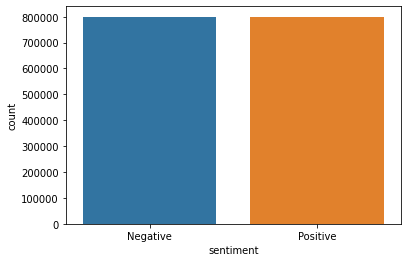

In [96]:
plt.figure()
sns.countplot(data['sentiment'])
print(data['sentiment'].value_counts())

**3. Preprocessing**

In [97]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', text)
    text = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', text)
    text = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', text)
    text = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', text)
    text = re.sub("[^a-z0-9<>]", ' ', text)
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

Test a tweet to see the difference before and after preprocessing

In [98]:
data.tweet[24821]

"I say &quot;I've got a 16GB flashdrive&quot;. He says &quot;I *saw* a 64GB flashdrive&quot;. Somehow his statement trumps mine. "

In [99]:
preprocess(data.tweet[24821], True)

'say quot got 16gb flashdriv quot say quot saw 64gb flashdriv quot somehow statement trump mine'

Apply preprocessing to all the data

In [100]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result school today also blah
2,Negative,dived many times ball managed save 50 rest go bounds
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


Pull data about specific topics to and see how many tweets are positive versus negative about this topic

In [101]:
data = shuffle(data)
searchWords = '|'.join(['sport', 'player', 'game', 'ball', 'score', 'winner'])
filtered = data[data['tweet'].str.contains(searchWords, case=False)]
pd.set_option('display.max_colwidth', 0)
print("Amount of positive tweets:", filtered['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered['sentiment'].value_counts()['Negative'])
filtered.head(10)

Amount of positive tweets: 11747
Amount of negative tweets: 12274


,sentiment,tweet
1150926,Positive,oh yeah movie review 3 thumbs 2 minutes already balling seriously
409842,Negative,home chinese food wal mart saw twilight game money get sad kitten
900918,Positive,also thanks coming playing party games pics good
873646,Positive,ball chain shrew partner governor apply
180626,Negative,got done volleyball tryouts didnt well needs step
438732,Negative,unfortunately stupid amp picked shift overlaps men league playoff game
1152385,Positive,hear people talking fuzzball lakers
539672,Negative,feel judged prefer ball player dude love happens b furthest thing
874459,Positive,ppv partit comprat ppv game bought
935917,Positive,hey danregal get quot put twitter handle middle quot game see tweets boxspring andy065


In [102]:
searchWords = '|'.join(['job', 'work', 'weekday', 'commute'])
filtered1 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered1['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered1['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered1.head(10)

Amount of positive tweets: 35628
Amount of negative tweets: 67046


,sentiment,tweet
539380,Negative,really hates working server work one 3 4 people seem quot slowsky quot problem
1486765,Positive,mobile web version work properly maybe add search function
1297189,Positive,co worker counted trying guess amount looking forward hitting 100
1590075,Positive,back work ready week
134834,Negative,beautiful outside mad gotta b work day
302627,Negative,way work u love hurts
769290,Negative,miss guys got home work watching videos shows
137358,Negative,bank holiday monday consist working
1421992,Positive,working websites today little bit designing lets see works love web development
1367663,Positive,hey never said would quality could take lol could job probs


In [103]:
searchWords = '|'.join(['Obama', 'Trump', 'politics', 'president', 'election'])
filtered2 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered2['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered2['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered2.head(10)

Amount of positive tweets: 978
Amount of negative tweets: 1209


,sentiment,tweet
1295337,Positive,believe find channels prodcasting sports channels league days obama egypt sadekhm
1478609,Positive,voting european elections next eu parliament must take war poverty defense human rights serioulsy
945055,Positive,thank glad enjoying ice cream selection
1385718,Positive,radio smile funny planet green pleasant gorgeous trumpet
852166,Positive,last point night promise obama may quot self identify quot black still erase whiteness
1382543,Positive,missed gh karbaschi twitter welcome gkarbaschi iran election wp
198173,Negative,immigrant cannot vote danish elections unfair
817061,Positive,great time bring trumpets
1572268,Positive,calling americans brain iranelection stop american idiot free iran
426961,Negative,reading newspaper shower afterwards going euro election sure exciting boobs


In [104]:
processedtext = list(data.tweet)
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

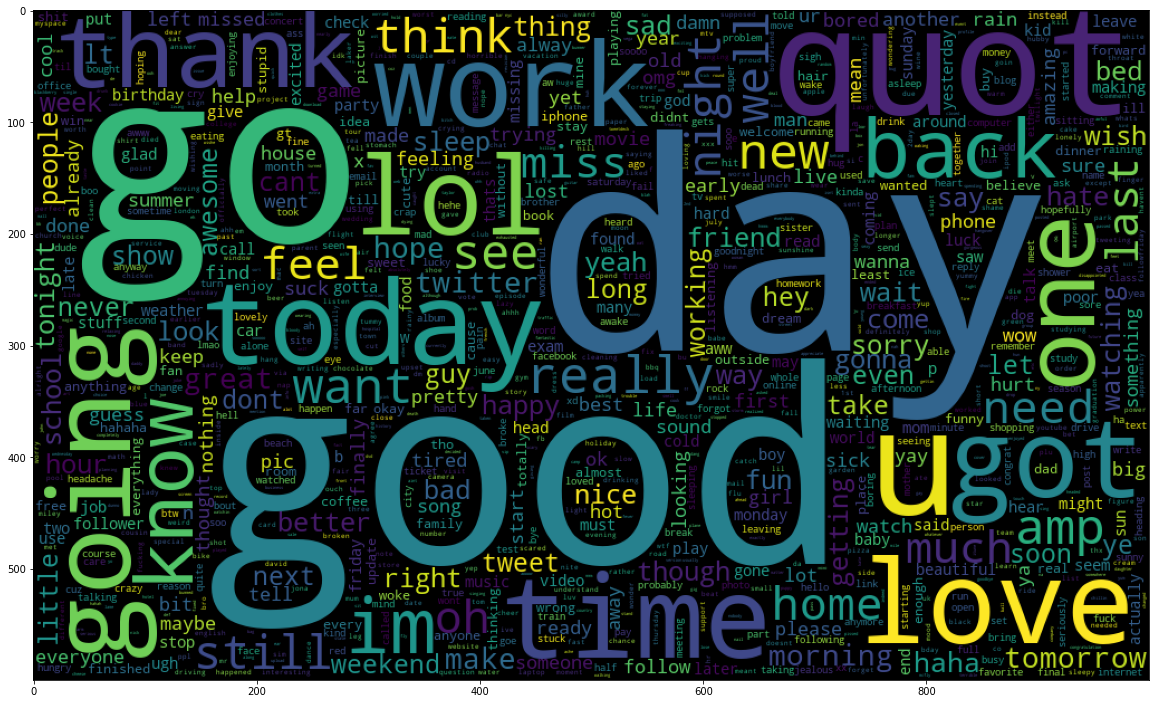

In [105]:
word_cloud = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(word_cloud)

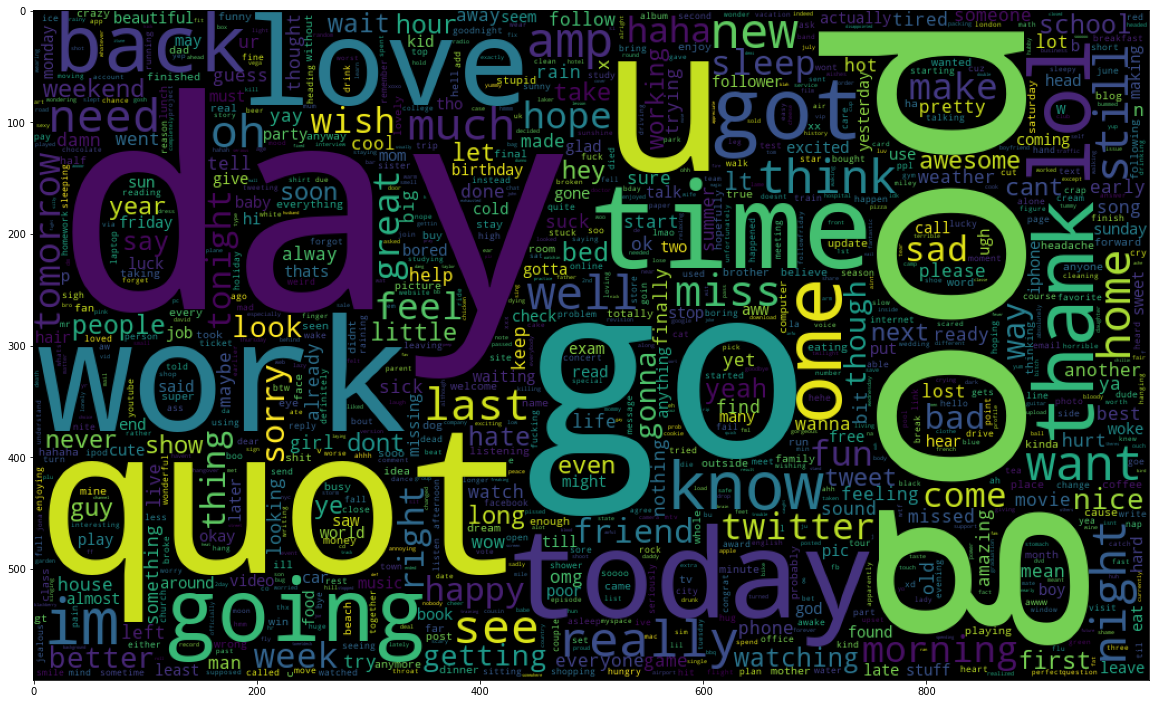

In [106]:
wc = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

**4. Split data into training and testing sets**

In [107]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [108]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [109]:
train_data.head()

,sentiment,tweet
1533882,Positive,fmj great film even bit hardcore like films
769105,Negative,ur top car top lol jk raining like 2 wks hav
475921,Negative,god choice book update book today delays due page numbering index shooting 22nd
1500723,Positive,rawk
1017306,Positive,got home church good day whew


In [110]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 291049


In [111]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [112]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


Import word embeddings and create representations of word vectors for the tweets in our dataset. 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-09 20:47:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-09 20:47:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-09 20:47:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**5. Begin Training**

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [ ]:
input_shape = Input(shape = (max_length), dtype = 'int32')
embedding_sequence = embedding_layer(input_shape)
x = SpatialDropout1D(0.2)(embedding_sequence)
x = Conv1D(64, 5, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
output = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(input_shape, output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [reduction])

**6. Accuracy and Predictions**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'blue', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'blue', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend(loc='upper right')

In [ ]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'
        
scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [ ]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Precision, recall, and f1-score of the model

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_D))

In [ ]:
def final_sentiment(score):
    if score > 0.6:
            return 'Positive'
    elif (score > 0.4 and score < 0.6):
            return 'Neutral'
    else:
            return'Negative'
        
def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = final_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

**7. Test model on actual tweets**

Pull tweets from a certain user (Elon Musk).

In [ ]:
posts = api.user_timeline(screen_name = "elonmusk", count = 10, lang = "en", tweet_mode="extended")

sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

print('--------Tweets: ')
print('\n')

for tweet in posts:
    print(tweet.full_text)
    prediction = pred(tweet.full_text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
    
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))
if avg > 0.6:
    print('The final grade is therefore positive.')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral.')
else:
    print('The final grade is therefore negative.')

Pull tweets about a certain topic (sports).

In [ ]:
search_term = '|'.join(['sport', 'player', 'game', 'ball'])

tweet_amount = 5
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')  

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

In [ ]:
search_term = '|'.join(['work', 'job', 'commute'])
tweet_amount = 5
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

Pull tweets with certain queries (cars)

In [ ]:
client = tweepy.Client(bearer_token = 'AAAAAAAAAAAAAAAAAAAAADvCkQEAAAAAqBldguiK%2FewFmwE1Cpd1UbQrlew%3D4Ysvdx21ITFfLHDHTL5nnV8q5KCNJ8dOLrYf23yIE8S3OOnCvw')
query = '#cars -is:retweet lang:en'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

for tweet in tweets.data:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')